# imports and loading DataFrame

In [526]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime

DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
PRICE_TRESHOLD = 100_000
WEIGHT_TRESHOLD = 50


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

# adding a column with time difference in deliveries
adding a column with time difference between purchase_timestamp and delivery_timestamp in deliveries table

1. Cut microseconds from delivery_timestamp, so it will be the same format as purchase_timestamp, because there are no microseconds in purchase_timestamp (using "." as a separator).
2. Change columns format to datetime
3. Add time_diff column (as timedelta64 object).
4. Drop rows where time_diff is null (which means that delivery_timestamp was null).
5. Change type of time_diff from timedelta64 to seconds in float.
6. Drop rows where time_diff is below 0.

In [527]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
# deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]


# deliveries_df.info()
# deliveries_df.head()

# join deliveries with sessions

In [528]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

# df.info()
# df.head()

In [529]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

# df.info()
# df.head()

# join with other tables

In [530]:
df = df.merge(users_df, on="user_id", how="left")
df = df.merge(products_df, on="product_id", how="left")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 0 to 5781
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   purchase_id          5782 non-null   int64         
 1   purchase_timestamp   5782 non-null   datetime64[ns]
 2   delivery_timestamp   5782 non-null   datetime64[ns]
 3   delivery_company     5473 non-null   float64       
 4   time_diff            5782 non-null   float64       
 5   session_id           5782 non-null   int64         
 6   user_id              5485 non-null   float64       
 7   product_id           5469 non-null   float64       
 8   event_type           5782 non-null   object        
 9   offered_discount     5782 non-null   int64         
 10  name                 5485 non-null   object        
 11  city                 5485 non-null   object        
 12  street               5485 non-null   object        
 13  product_name         5469 non-nul

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_diff,session_id,user_id,product_id,event_type,offered_discount,name,city,street,product_name,category_path,price,brand,weight_kg,optional_attributes
0,20001,2022-03-04 12:00:32,2022-03-05 04:43:47,516.0,60195.0,124,102.0,1432.0,BUY_PRODUCT,15,Łukasz Pazera,Kraków,al. Skośna 265,Myszka przewodowa Defender Myszka Dla Graczy G...,Myszki;Przewodowe,-69.00,Defender,0.170,{'color': 'czarny'}
1,20002,2022-02-24 09:04:00,2022-02-24 00:01:00,516.0,-32580.0,126,102.0,1608.0,BUY_PRODUCT,20,Łukasz Pazera,Kraków,al. Skośna 265,Gogle VR Esperanza VR3DEAPSTD$VRPILOTBT,Urządzenia VR;Gogle VR,59.00,Esperanza,0.200,{}
2,20003,2022-02-23 01:05:44,2022-02-24 08:09:17,620.0,111813.0,128,102.0,1095.0,BUY_PRODUCT,20,Łukasz Pazera,Kraków,al. Skośna 265,Kabel DisplayPort Unitek C1608BNI czarny 2m,Kable i przedłużacze;DisplayPort,-58.99,Unitek,0.055,{}
3,20004,2022-01-12 19:51:01,2022-01-15 16:13:50,360.0,246169.0,129,102.0,1169.0,BUY_PRODUCT,20,Łukasz Pazera,Kraków,al. Skośna 265,Słuchawki nauszne Esperanza Blackbird,Mikrofony i słuchawki;Słuchawki przewodowe,29.99,Esperanza,0.000,{'color': 'czarny'}
4,20005,2022-03-16 20:50:14,2022-03-20 08:42:59,516.0,301965.0,130,102.0,1433.0,BUY_PRODUCT,5,Łukasz Pazera,Kraków,al. Skośna 265,Myszka przewodowa Defender Myszka Dla Graczy G...,Myszki;Przewodowe,44.00,Defender,0.220,{'color': 'czarny'}


# visualizations

## time_diff histogram

C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


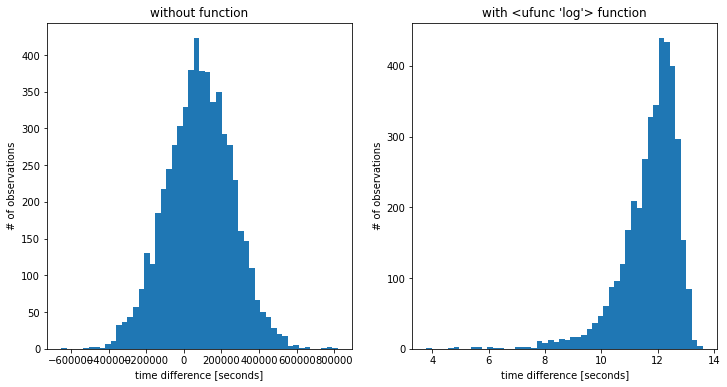

In [531]:
fig, ax = plt.subplots(1, 2)

def plot_hist(x, num_bins=50, func=None):
    if func:
        ax[x].hist(func(df["time_diff"]), bins=num_bins)
        ax[x].set_title(f"with {func} function")
    else:
        ax[x].hist(df["time_diff"], bins=num_bins)
        ax[x].set_title(f"without function")
    ax[x].set_xlabel("time difference [seconds]")
    ax[x].set_ylabel("# of observations")

plot_hist(0)
plot_hist(1, func=np.log)
# plot_hist(1, 0, func=np.log2)
# plot_hist(1, 1, func=np.log10)

fig.set_size_inches([12, 6])
plt.show()

## histograms of continuous variables

In [532]:
NUM_BINS = 50


def plot_histograms(input_df):
    fig, ax = plt.subplots(2, 2)

    def plot_hist(x, y, col_name, num_bins=None):
        if num_bins:
            ax[x, y].hist(input_df[col_name], bins=num_bins)
        else:
            ax[x, y].hist(input_df[col_name])
        ax[x, y].set_title(f"histogram of {col_name}")
        ax[x, y].set_xlabel(col_name)
        ax[x, y].set_ylabel("# of observations")

    plot_hist(0, 0, "time_diff", NUM_BINS)
    plot_hist(0, 1, "offered_discount", NUM_BINS)
    plot_hist(1, 0, "price", NUM_BINS)
    plot_hist(1, 1, "weight_kg", NUM_BINS)

    fig.set_size_inches([12, 12])
    plt.show()

### with outliers

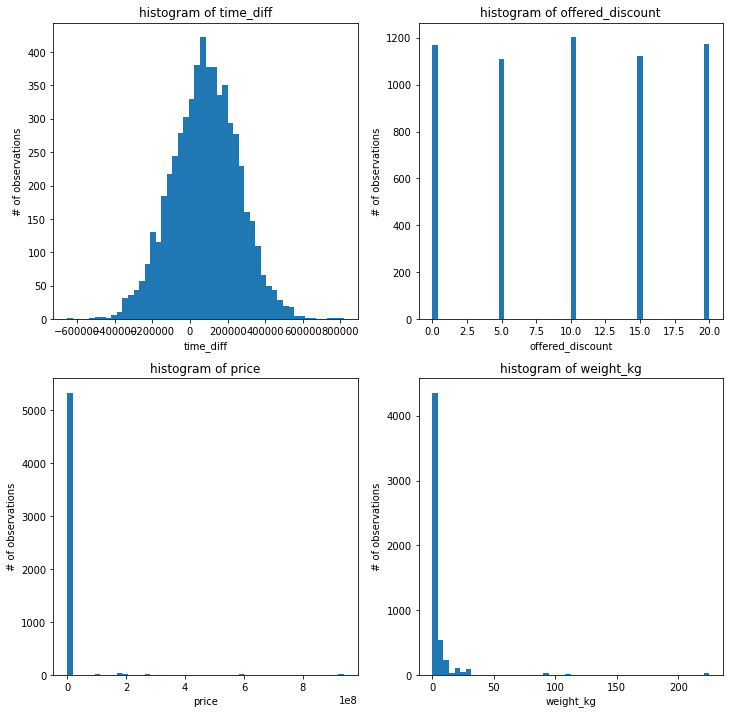

In [533]:
plot_histograms(df)

### without outliers

In [534]:
# rejecting outliers for given PRICE_TRESHOLD
df = df[df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
df = df[df["weight_kg"] <= WEIGHT_TRESHOLD]

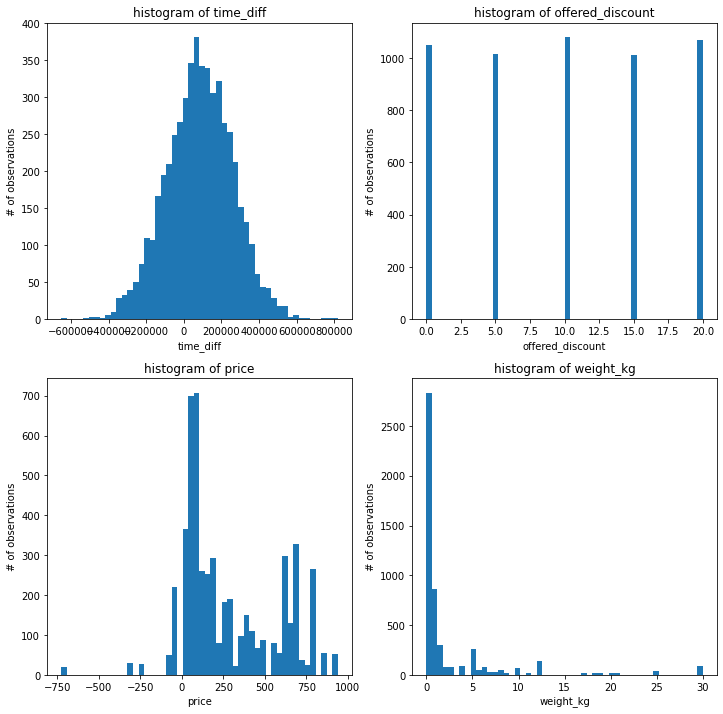

In [535]:
plot_histograms(df)

### without prices below 0

In [536]:
# deleting rows with prices below 0
df = df[df["price"] >= 0]

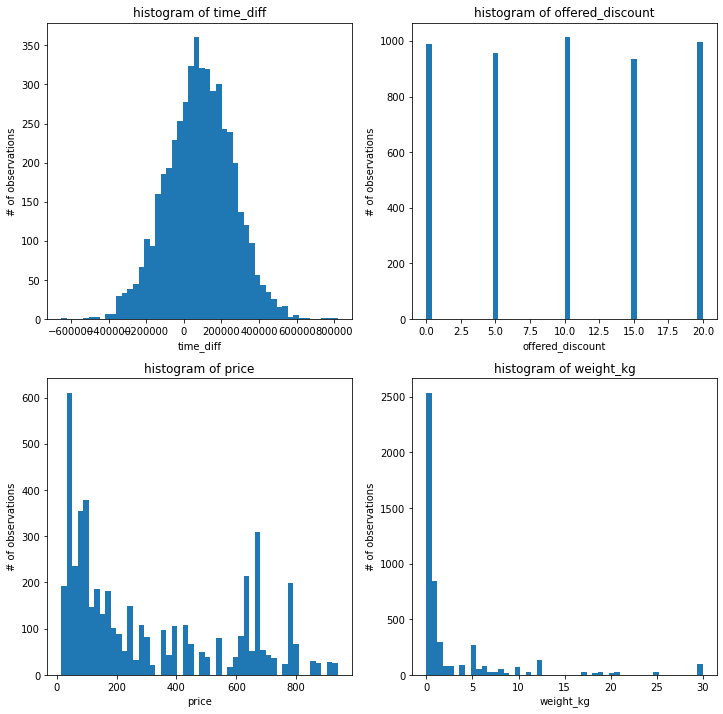

In [537]:
plot_histograms(df)

### without time_diff below 0

In [538]:
df_without_time_diff_below_0 = df[df["time_diff"] >= 0]

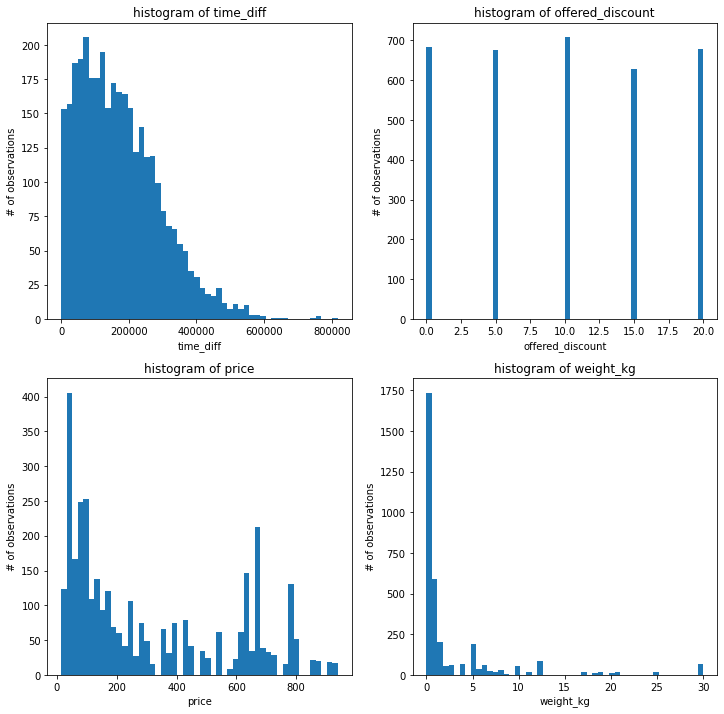

In [539]:
plot_histograms(df_without_time_diff_below_0)

## heatmap

### with time_diff below zero

In [540]:
columns_list = ["time_diff", "offered_discount", "price", "weight_kg"]

(4888, 19)


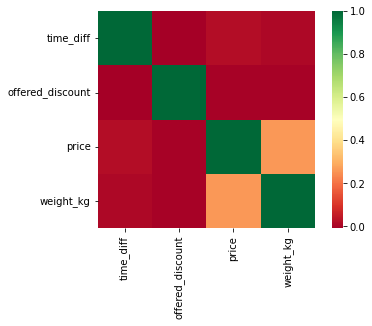

In [541]:
print(df.shape)
ax = sns.heatmap(df[columns_list].corr(), square=True, cmap='RdYlGn')

### without time_diff below zero

(3375, 19)


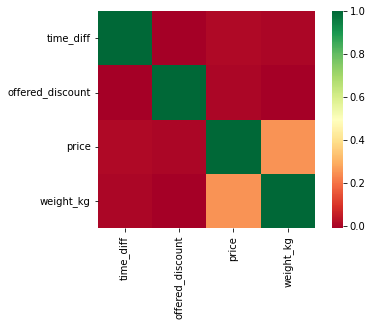

In [542]:
print(df_without_time_diff_below_0.shape)
ax = sns.heatmap(df_without_time_diff_below_0[columns_list].corr(), square=True, cmap='RdYlGn')

## Cramer's V

In [543]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [544]:
# cramers_v()